In [1]:
import numpy as np                                          # 导入numpy库并简写为np
from mindquantum.core.circuit import Circuit                # 导入Circuit模块，用于搭建量子线路
from mindquantum.core.gates import H, RX, RY, RZ            # 导入量子门H, RX, RY, RZ
from mindquantum.core.parameterresolver import PRGenerator  # 导入参数生成器模块

                 Circuit Summary                 
╭──────────────────────┬────────────────────────╮
│ Info                 │ value                  │
├──────────────────────┼────────────────────────┤
│ Number of qubit      │ 1                      │
├──────────────────────┼────────────────────────┤
│ Total number of gate │ 4                      │
│ Barrier              │ 0                      │
│ Noise Channel        │ 0                      │
│ Measurement          │ 0                      │
├──────────────────────┼────────────────────────┤
│ Parameter gate       │ 3                      │
│ 3 encoder parameters │ alpha0, alpha1, alpha2 │
╰──────────────────────┴────────────────────────╯

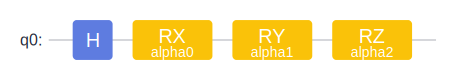

In [2]:
alpha = PRGenerator('alpha')
encoder = Circuit()
encoder += H.on(0)
encoder += RX(alpha.new()).on(0)
encoder += RY(alpha.new()).on(0)
encoder += RZ(alpha.new()).on(0)
encoder = encoder.no_grad()
encoder.as_encoder()
encoder.summary()
encoder.svg()

In [3]:
alpha0, alpha1, alpha2 = 0.2, 0.3, 0.4

In [4]:
state = encoder.get_qs(pr={'alpha0': alpha0, 'alpha1': alpha1, 'alpha2': alpha2}, ket=True)
print(state)

(0.56699031-0.17539066j)¦0⟩
(0.80081463+0.08034947j)¦1⟩


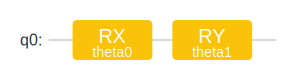

In [6]:
theta = PRGenerator('theta')
ansatz = Circuit()
ansatz += RX(f'theta{0}').on(0)
ansatz += RY(f'theta{1}').on(0)
ansatz.as_ansatz()
ansatz.svg()

In [8]:
theta0, theta1 = 0, 0
state = ansatz.get_qs(pr={'theta0': theta0, 'theta1': theta1}, ket=True)
print(state)

1¦0⟩


                 Circuit Summary                 
╭──────────────────────┬────────────────────────╮
│ Info                 │ value                  │
├──────────────────────┼────────────────────────┤
│ Number of qubit      │ 1                      │
├──────────────────────┼────────────────────────┤
│ Total number of gate │ 6                      │
│ Barrier              │ 0                      │
│ Noise Channel        │ 0                      │
│ Measurement          │ 0                      │
├──────────────────────┼────────────────────────┤
│ Parameter gate       │ 5                      │
│ 3 encoder parameters │ alpha0, alpha1, alpha2 │
│ 2 ansatz parameters  │ theta0, theta1         │
╰──────────────────────┴────────────────────────╯

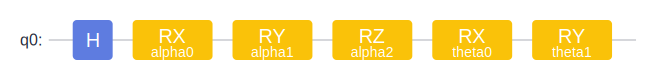

In [9]:
circuit = encoder.as_encoder() + ansatz.as_ansatz()
circuit.summary()
circuit.svg()

In [10]:
from mindquantum.core.operators import QubitOperator
from mindquantum.core.operators import Hamiltonian

ham = Hamiltonian(QubitOperator('Z0', -1))
print(ham)

-1 [Z0]


In [11]:
encoder_names = encoder.params_name
ansatz_names = ansatz.params_name

print(encoder_names, ansatz_names)

['alpha0', 'alpha1', 'alpha2'] ['theta0', 'theta1']


In [14]:
from mindquantum.simulator import Simulator

sim = Simulator('mqvector', circuit.n_qubits)
grad_ops = sim.get_expectation_with_grad(ham, circuit)

encoder_data = np.array([[alpha0, alpha1, alpha2]]).astype(np.float32)
ansatz_data = np.array([theta0, theta1]).astype(np.float32)

measure_result, encoder_grad, ansatz_grad = grad_ops(encoder_data, ansatz_data)

print('Measurement result:', measure_result)
print('Gradient of encoder parameters:', encoder_grad)
print('Gradient of ansatz parameters:', ansatz_grad)

Measurement result: [[0.29552022+4.14621057e-18j]]
Gradient of encoder parameters: [[[0.+0.j 0.+0.j 0.+0.j]]]
Gradient of ansatz parameters: [[[-0.37202556+0.j  0.87992317+0.j]]]


In [18]:
from mindquantum.framework import MQLayer
import mindspore as ms

ms.set_seed(1)
ms.set_device('CPU')
ms.set_context(mode=ms.PYNATIVE_MODE)

QuantumNet = MQLayer(grad_ops)
QuantumNet

MQLayer<
  (evolution): MQOps<1 qubit mqvector VQA Operator>
  >

In [22]:
from mindspore.nn import Adam, TrainOneStepCell

opti = Adam(QuantumNet.trainable_params(), learning_rate=0.1)
net = TrainOneStepCell(QuantumNet, opti)

for i in range(200):
    res = net(ms.Tensor(encoder_data))
    if i % 10 == 0:
        print(i, ':', res)

0 : [[-0.891785]]
10 : [[-0.9809836]]
20 : [[-0.99586666]]
30 : [[-0.99958545]]
40 : [[-0.9999468]]
50 : [[-0.99996686]]
60 : [[-0.99999505]]
70 : [[-0.99999887]]
80 : [[-0.9999979]]
90 : [[-0.9999984]]
100 : [[-0.9999984]]
110 : [[-0.9999993]]
120 : [[-0.9999998]]
130 : [[-1.]]
140 : [[-1.]]
150 : [[-1.]]
160 : [[-1.]]
170 : [[-1.]]
180 : [[-1.]]
190 : [[-1.]]


In [24]:
theta0, theta1 = QuantumNet.weight.asnumpy()
print(QuantumNet.weight.asnumpy())

[ 2.2420797 -1.0756938]


In [25]:
pr = {'alpha0': alpha0, 'alpha1': alpha1, 'alpha2': alpha2, 'theta0': theta0, 'theta1': theta1}
state = circuit.get_qs(pr=pr, ket=True)
print(state)

(0.37127627-0.92852244j)¦0⟩
(2.49e-06-2.58e-06j)¦1⟩
